In [1]:
trial_number_ml = "009"
random_state_init = 999

In [2]:
# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# optuna
import optuna
import optuna.integration.lightgbm as lgb_optuna
from optuna.pruners import MedianPruner
from optuna.integration import OptunaSearchCV

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


# metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

#lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns


from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole # Enables RDKit's IPython integration for Jupyter notebooks.
from IPython.display import display


import os
from rdkit.Chem.Draw import rdMolDraw2D

import joblib


# %%
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
import os

# Get the current working directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Verify the change
new_dir = os.getcwd()
print("New Working Directory:", new_dir)


Current Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n
New Working Directory: /home/ubuntu/diplomka/notebooks_ipynb/ml/model1_rna_b_rna_n


In [4]:
def load_and_concatenate_datasets(file_paths):
    """
    Load datasets from given file paths and concatenate them into a single DataFrame.
    """
    dataframes = [pd.read_pickle(path) for path in file_paths]
    return pd.concat(dataframes, ignore_index=True)

def preprocess_data(df, feature_col='ecfp6', label_col='label'):
    """
    Preprocess the DataFrame by extracting features and labels.
    """
    X = np.array([list(map(int, list(fp))) for fp in df[feature_col]])
    y = df[label_col].values
    return X, y

def stratified_train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Split the dataset into training and test sets, ensuring stratification of the target variable.
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Paths for the datasets
model1_files = ['../../data_for_ml/ml_datasets_set2/model1_rna_bin_non_rna_bin/data.pkl']

# Load datasets
model1_df = load_and_concatenate_datasets(model1_files)

# Preprocess datasets
X1, y1 = preprocess_data(model1_df)

# Split datasets
X_train, X_test, y_train, y_test = stratified_train_test_split(X1, y1)

# Output shapes
print(f"Model 1 - Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


Model 1 - Training set size: 3137, Test set size: 785


In [5]:
import numpy as np
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from optuna.integration import OptunaSearchCV


def model_training_and_evaluation(model, X_train, y_train, X_test, y_test):
    """
    Train and evaluate a model using given datasets.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return model, accuracy

def objective(trial, model_cls, X_train, y_train):
    """
    Objective function for hyperparameter tuning with Optuna.
    
    Args:
    - trial (optuna.trial.Trial): An individual trial object.
    - model_cls: The classifier class to be optimized.
    - X_train, y_train: Training data.
    
    Returns:
    - The accuracy of the model on the cross-validation folds.
    """
    # Suggest hyperparameters specific to the RandomForestClassifier
    if model_cls == RandomForestClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        max_depth = trial.suggest_int('max_depth', 10, 100)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        
        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                          min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                          max_features=max_features, random_state=random_state_init, n_jobs=4)
        
    elif model_cls == XGBClassifier:
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        subsample = trial.suggest_float('subsample', 0.5, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
        gamma = trial.suggest_float('gamma', 0, 5)
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10.0, log=True)
        reg_alpha = trial.suggest_float('reg_alpha', 0.01, 10.0, log=True)

        model = model_cls(n_estimators=n_estimators, max_depth=max_depth,
                        learning_rate=learning_rate, min_child_weight=min_child_weight,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        gamma=gamma, reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                        random_state=random_state_init, use_label_encoder=False, eval_metric='logloss', n_jobs=4)
    
    elif model_cls == LGBMClassifier:
        boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss'])
        num_leaves = trial.suggest_int('num_leaves', 31, 100)
        max_depth = trial.suggest_int('max_depth', -1, 15)
        learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5)
        n_estimators = trial.suggest_int('n_estimators', 100, 1000)
        min_child_weight = trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True)
        min_child_samples = trial.suggest_int('min_child_samples', 20, 2000)
        subsample = trial.suggest_float('subsample', 0.8, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.8, 1.0)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-10, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-10, 1.0, log=True)
        
        model = model_cls(boosting_type=boosting_type, num_leaves=num_leaves, max_depth=max_depth,
                        learning_rate=learning_rate, n_estimators=n_estimators,
                        min_child_weight=min_child_weight, min_child_samples=min_child_samples,
                        subsample=subsample, colsample_bytree=colsample_bytree,
                        reg_alpha=reg_alpha, reg_lambda=reg_lambda, random_state=random_state_init, verbosity=-1, n_jobs=4)
    else:
        raise NotImplementedError("Optuna objective function needs to be extended for other classifiers.")
    
    # Cross-validation within the Optuna trial
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_init)
    accuracies = []
    for train_index, val_index in stratified_kfold.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict(X_fold_val)
        accuracy = accuracy_score(y_fold_val, y_fold_pred)
        accuracies.append(accuracy)
        
        trial.report(np.mean(accuracies), len(accuracies))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return np.mean(accuracies)

def perform_hyperparameter_tuning(model_cls, X_train, y_train, n_trials=50):
    """
    Perform hyperparameter tuning for the given model class using Optuna.
    """
    study = optuna.create_study(direction='maximize')
    objective_with_model = lambda trial: objective(trial, model_cls, X_train, y_train)
    study.optimize(objective_with_model, n_trials=n_trials, n_jobs=4) 
    
    print(f"Best trial for {model_cls.__name__}:")
    print(f"  Value: {study.best_trial.value}")
    print("  Params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
    print('')
    return study.best_params

print('')
# Example usage for RandomForestClassifier
best_params_rf = perform_hyperparameter_tuning(RandomForestClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for RandomForestClassifier:", best_params_rf)
# Train and evaluate the final model with the best hyperparameters
best_rf = RandomForestClassifier(**best_params_rf, random_state=random_state_init)
final_model, final_accuracy = model_training_and_evaluation(best_rf, X_train, y_train, X_test, y_test)
print(f"RandomForestClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for XGBClassifier
best_params_xgb = perform_hyperparameter_tuning(XGBClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for XGBClassifier:", best_params_xgb)
# Train and evaluate the final model with the best hyperparameters
best_xgb = XGBClassifier(**best_params_xgb, random_state=random_state_init, use_label_encoder=False, eval_metric='logloss')
final_model, final_accuracy = model_training_and_evaluation(best_xgb, X_train, y_train, X_test, y_test)
print(f"XGBClassifier accuracy: {final_accuracy:.4f}")
print('')

# Example usage for LGBMClassifier
best_params_lgb = perform_hyperparameter_tuning(LGBMClassifier, X_train, y_train, n_trials=50)
print("Best hyperparameters for LGBMClassifier:", best_params_lgb)
# Train and evaluate the final model with the best hyperparameters
best_lgb = LGBMClassifier(**best_params_lgb, random_state=random_state_init, verbosity=-1)
final_model, final_accuracy = model_training_and_evaluation(best_lgb, X_train, y_train, X_test, y_test)
print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")

print(f"LGBMClassifier accuracy: {final_accuracy:.4f}")
print('')


[I 2024-05-01 18:05:09,024] A new study created in memory with name: no-name-27214e68-3e58-4343-a509-46909054bf01


[I 2024-05-01 18:05:29,606] Trial 1 finished with value: 0.6136348398500594 and parameters: {'n_estimators': 126, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.6136348398500594.


[I 2024-05-01 18:05:40,086] Trial 3 finished with value: 0.6247935269557796 and parameters: {'n_estimators': 151, 'max_depth': 43, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.6247935269557796.


[I 2024-05-01 18:06:32,000] Trial 0 finished with value: 0.6161887056959132 and parameters: {'n_estimators': 653, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.6247935269557796.


[I 2024-05-01 18:07:12,587] Trial 6 finished with value: 0.6209723788335924 and parameters: {'n_estimators': 292, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 3 with value: 0.6247935269557796.


[I 2024-05-01 18:07:16,196] Trial 5 finished with value: 0.6104475868304229 and parameters: {'n_estimators': 788, 'max_depth': 12, 'min_samples_split': 15, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 3 with value: 0.6247935269557796.


[I 2024-05-01 18:07:39,452] Trial 7 pruned. 


[I 2024-05-01 18:08:05,636] Trial 2 finished with value: 0.6273438373002571 and parameters: {'n_estimators': 934, 'max_depth': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 0.6273438373002571.


[I 2024-05-01 18:08:07,469] Trial 9 finished with value: 0.6209754264062008 and parameters: {'n_estimators': 131, 'max_depth': 80, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6273438373002571.


[I 2024-05-01 18:08:38,284] Trial 8 finished with value: 0.6311660012799806 and parameters: {'n_estimators': 470, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 8 with value: 0.6311660012799806.


[I 2024-05-01 18:08:48,738] Trial 12 pruned. 


[I 2024-05-01 18:08:51,241] Trial 4 finished with value: 0.6321229390790236 and parameters: {'n_estimators': 998, 'max_depth': 52, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:09:26,519] Trial 11 finished with value: 0.6209678074746797 and parameters: {'n_estimators': 534, 'max_depth': 52, 'min_samples_split': 16, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:09:57,214] Trial 10 finished with value: 0.6263863915724459 and parameters: {'n_estimators': 576, 'max_depth': 85, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:10:22,090] Trial 13 finished with value: 0.6254319934172432 and parameters: {'n_estimators': 508, 'max_depth': 33, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:10:33,522] Trial 14 finished with value: 0.6305290586048213 and parameters: {'n_estimators': 541, 'max_depth': 34, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:11:02,610] Trial 15 finished with value: 0.6267068946250978 and parameters: {'n_estimators': 518, 'max_depth': 32, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:11:24,868] Trial 16 finished with value: 0.630527534818517 and parameters: {'n_estimators': 456, 'max_depth': 28, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:12:52,772] Trial 17 finished with value: 0.6286197543656478 and parameters: {'n_estimators': 768, 'max_depth': 69, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:13:03,425] Trial 18 finished with value: 0.628300267170532 and parameters: {'n_estimators': 764, 'max_depth': 65, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:13:35,812] Trial 19 finished with value: 0.6276633244953728 and parameters: {'n_estimators': 783, 'max_depth': 71, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.6321229390790236.


[I 2024-05-01 18:13:56,950] Trial 20 finished with value: 0.6327629293267912 and parameters: {'n_estimators': 736, 'max_depth': 68, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:14:17,448] Trial 22 finished with value: 0.6283012830280682 and parameters: {'n_estimators': 370, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:15:00,210] Trial 23 finished with value: 0.6270279056065177 and parameters: {'n_estimators': 363, 'max_depth': 47, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:15:46,987] Trial 21 finished with value: 0.6257504647548228 and parameters: {'n_estimators': 721, 'max_depth': 66, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:17:06,389] Trial 25 finished with value: 0.631170064710125 and parameters: {'n_estimators': 632, 'max_depth': 24, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:18:00,679] Trial 24 finished with value: 0.6318004043112995 and parameters: {'n_estimators': 876, 'max_depth': 47, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:19:07,282] Trial 26 finished with value: 0.6305315982486616 and parameters: {'n_estimators': 884, 'max_depth': 60, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:19:20,369] Trial 27 finished with value: 0.6286141671491989 and parameters: {'n_estimators': 878, 'max_depth': 59, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:20:25,621] Trial 28 finished with value: 0.6251114903645912 and parameters: {'n_estimators': 888, 'max_depth': 59, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:21:04,604] Trial 29 finished with value: 0.6244735318318958 and parameters: {'n_estimators': 902, 'max_depth': 59, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:21:51,083] Trial 30 finished with value: 0.6260658885197941 and parameters: {'n_estimators': 871, 'max_depth': 59, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:21:59,678] Trial 31 finished with value: 0.6263838519286055 and parameters: {'n_estimators': 849, 'max_depth': 42, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:23:57,587] Trial 32 finished with value: 0.6282992513129958 and parameters: {'n_estimators': 977, 'max_depth': 73, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:24:30,087] Trial 34 finished with value: 0.6279797641178801 and parameters: {'n_estimators': 680, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:25:01,139] Trial 33 finished with value: 0.6235176098903888 and parameters: {'n_estimators': 999, 'max_depth': 76, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:25:29,547] Trial 38 pruned. 


[I 2024-05-01 18:25:43,648] Trial 35 finished with value: 0.6276582452076921 and parameters: {'n_estimators': 991, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:25:46,365] Trial 39 pruned. 


[I 2024-05-01 18:26:03,885] Trial 40 pruned. 


[I 2024-05-01 18:26:08,821] Trial 36 finished with value: 0.6241520129217079 and parameters: {'n_estimators': 654, 'max_depth': 76, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:26:14,134] Trial 41 pruned. 


[I 2024-05-01 18:26:37,902] Trial 37 finished with value: 0.6311654933512124 and parameters: {'n_estimators': 606, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:26:42,835] Trial 44 pruned. 


[I 2024-05-01 18:26:44,230] Trial 43 pruned. 


[I 2024-05-01 18:27:09,877] Trial 46 pruned. 


[I 2024-05-01 18:28:26,189] Trial 47 finished with value: 0.623517609890389 and parameters: {'n_estimators': 468, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:28:54,559] Trial 48 finished with value: 0.6295716128770101 and parameters: {'n_estimators': 461, 'max_depth': 28, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:28:57,459] Trial 42 finished with value: 0.6327578500391106 and parameters: {'n_estimators': 715, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:29:07,060] Trial 49 finished with value: 0.6257499568260547 and parameters: {'n_estimators': 224, 'max_depth': 41, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


[I 2024-05-01 18:29:07,438] Trial 45 finished with value: 0.6241479494915634 and parameters: {'n_estimators': 934, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 20 with value: 0.6327629293267912.


Best trial for RandomForestClassifier:
  Value: 0.6327629293267912
  Params: 
    n_estimators: 736
    max_depth: 68
    min_samples_split: 9
    min_samples_leaf: 2
    max_features: sqrt

Best hyperparameters for RandomForestClassifier: {'n_estimators': 736, 'max_depth': 68, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


[I 2024-05-01 18:29:23,521] A new study created in memory with name: no-name-712199dd-d08e-4599-a3f2-48e7bcf2b439


RandomForestClassifier accuracy: 0.6229



[I 2024-05-01 18:29:35,657] Trial 2 finished with value: 0.6050264630888165 and parameters: {'n_estimators': 130, 'max_depth': 8, 'learning_rate': 0.2698678419898447, 'min_child_weight': 2, 'subsample': 0.7301379891556818, 'colsample_bytree': 0.7047175424692864, 'gamma': 4.662371885287568, 'reg_lambda': 9.014345236719791, 'reg_alpha': 2.1981857553983173}. Best is trial 2 with value: 0.6050264630888165.


[I 2024-05-01 18:29:44,128] Trial 1 finished with value: 0.6193779904306219 and parameters: {'n_estimators': 152, 'max_depth': 4, 'learning_rate': 0.07967169944663072, 'min_child_weight': 1, 'subsample': 0.6938173330255304, 'colsample_bytree': 0.5303626721037276, 'gamma': 1.7253439059235238, 'reg_lambda': 7.653468395777326, 'reg_alpha': 0.03231894054491705}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:29:48,968] Trial 3 finished with value: 0.6161887056959132 and parameters: {'n_estimators': 189, 'max_depth': 8, 'learning_rate': 0.11212799006145152, 'min_child_weight': 6, 'subsample': 0.7948531567386041, 'colsample_bytree': 0.7989680459291524, 'gamma': 2.662236732220134, 'reg_lambda': 0.025685606827070873, 'reg_alpha': 0.3005350160696674}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:29:51,804] Trial 4 finished with value: 0.6015283576631213 and parameters: {'n_estimators': 148, 'max_depth': 7, 'learning_rate': 0.18151651411836997, 'min_child_weight': 5, 'subsample': 0.5353783840768549, 'colsample_bytree': 0.783767674523902, 'gamma': 3.4991637277805685, 'reg_lambda': 0.8360786820020164, 'reg_alpha': 0.01569491461598054}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:30:15,827] Trial 5 finished with value: 0.6098101362264956 and parameters: {'n_estimators': 415, 'max_depth': 8, 'learning_rate': 0.07424109929673554, 'min_child_weight': 4, 'subsample': 0.8413256398322135, 'colsample_bytree': 0.5634674451342208, 'gamma': 4.899856435833746, 'reg_lambda': 8.903723835454599, 'reg_alpha': 0.013116628672994983}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:30:18,889] Trial 0 finished with value: 0.6053505216428448 and parameters: {'n_estimators': 740, 'max_depth': 3, 'learning_rate': 0.1731289215919449, 'min_child_weight': 1, 'subsample': 0.8599611479106624, 'colsample_bytree': 0.7846655770700259, 'gamma': 4.461177796598062, 'reg_lambda': 2.782653930729495, 'reg_alpha': 0.02594604321621409}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:30:22,373] Trial 9 pruned. 


[I 2024-05-01 18:30:28,718] Trial 6 finished with value: 0.6047191661841345 and parameters: {'n_estimators': 227, 'max_depth': 7, 'learning_rate': 0.17362681557449522, 'min_child_weight': 10, 'subsample': 0.7828897401066046, 'colsample_bytree': 0.5390433507173567, 'gamma': 0.4479466061308707, 'reg_lambda': 0.033749656679903366, 'reg_alpha': 0.5134966264672545}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:30:31,215] Trial 10 pruned. 


[I 2024-05-01 18:30:32,925] Trial 7 finished with value: 0.6015232783754406 and parameters: {'n_estimators': 337, 'max_depth': 5, 'learning_rate': 0.2743816208815156, 'min_child_weight': 8, 'subsample': 0.7495664253252023, 'colsample_bytree': 0.9264737288815795, 'gamma': 1.2953589695723449, 'reg_lambda': 0.08204717702446304, 'reg_alpha': 1.3438229907270647}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:30:35,138] Trial 12 pruned. 


[I 2024-05-01 18:30:36,417] Trial 11 pruned. 


[I 2024-05-01 18:30:39,226] Trial 8 finished with value: 0.6165102246061013 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.18050941851253094, 'min_child_weight': 1, 'subsample': 0.7835219565679883, 'colsample_bytree': 0.5133514638229767, 'gamma': 3.7325024921695427, 'reg_lambda': 0.3276272256554198, 'reg_alpha': 1.312064298315142}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:31:09,732] Trial 15 finished with value: 0.6180964861487824 and parameters: {'n_estimators': 222, 'max_depth': 6, 'learning_rate': 0.01399855557314883, 'min_child_weight': 7, 'subsample': 0.6483269111378062, 'colsample_bytree': 0.6311092907636512, 'gamma': 1.7753918297997056, 'reg_lambda': 0.010668493161870383, 'reg_alpha': 0.09692276562183694}. Best is trial 1 with value: 0.6193779904306219.


[I 2024-05-01 18:31:14,482] Trial 16 finished with value: 0.6228730482837087 and parameters: {'n_estimators': 231, 'max_depth': 5, 'learning_rate': 0.01623910780834885, 'min_child_weight': 1, 'subsample': 0.6539945181172511, 'colsample_bytree': 0.6318145095053473, 'gamma': 1.8798215876622866, 'reg_lambda': 1.8322718446619102, 'reg_alpha': 0.13475589465878376}. Best is trial 16 with value: 0.6228730482837087.


[I 2024-05-01 18:31:17,022] Trial 14 finished with value: 0.6279741769014313 and parameters: {'n_estimators': 208, 'max_depth': 9, 'learning_rate': 0.011436838196377141, 'min_child_weight': 3, 'subsample': 0.6399257328366696, 'colsample_bytree': 0.6442492021787568, 'gamma': 1.8497900466154975, 'reg_lambda': 0.011084997604151573, 'reg_alpha': 0.12705207383468506}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:31:17,133] Trial 18 pruned. 


[I 2024-05-01 18:31:30,116] Trial 17 finished with value: 0.6161836264082325 and parameters: {'n_estimators': 201, 'max_depth': 3, 'learning_rate': 0.015120853945186667, 'min_child_weight': 8, 'subsample': 0.656134779393797, 'colsample_bytree': 0.6292385317622695, 'gamma': 1.8099141152083649, 'reg_lambda': 0.012170300753695363, 'reg_alpha': 0.07763625475403257}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:31:55,740] Trial 21 finished with value: 0.615552270949522 and parameters: {'n_estimators': 286, 'max_depth': 9, 'learning_rate': 0.050810156045881565, 'min_child_weight': 3, 'subsample': 0.5582456943675265, 'colsample_bytree': 0.7096201699658465, 'gamma': 1.0830900013291558, 'reg_lambda': 1.2007501846043223, 'reg_alpha': 0.32629142216857615}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:31:58,837] Trial 22 pruned. 


[I 2024-05-01 18:31:59,475] Trial 13 finished with value: 0.6231981226952732 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.014868455907663308, 'min_child_weight': 3, 'subsample': 0.632976669914884, 'colsample_bytree': 0.6250314017409604, 'gamma': 1.7036281690033452, 'reg_lambda': 1.0034864798380208, 'reg_alpha': 0.09228811714563673}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:03,185] Trial 20 finished with value: 0.6114024929143937 and parameters: {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.053826529646765084, 'min_child_weight': 3, 'subsample': 0.5294249425399087, 'colsample_bytree': 0.6479726871851373, 'gamma': 0.9592514422775698, 'reg_lambda': 1.1737792692356832, 'reg_alpha': 0.09528290589795438}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:04,124] Trial 19 finished with value: 0.6247914952407074 and parameters: {'n_estimators': 497, 'max_depth': 9, 'learning_rate': 0.012343911301406786, 'min_child_weight': 3, 'subsample': 0.588710518438936, 'colsample_bytree': 0.6234468692832478, 'gamma': 1.3347126495969959, 'reg_lambda': 1.4824876616260705, 'reg_alpha': 0.1079022786228935}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:06,634] Trial 23 pruned. 


[I 2024-05-01 18:32:10,270] Trial 25 pruned. 


[I 2024-05-01 18:32:10,850] Trial 26 pruned. 


[I 2024-05-01 18:32:16,036] Trial 27 pruned. 


[I 2024-05-01 18:32:20,642] Trial 28 pruned. 


[I 2024-05-01 18:32:20,769] Trial 29 pruned. 


[I 2024-05-01 18:32:23,929] Trial 30 pruned. 


[I 2024-05-01 18:32:26,470] Trial 31 pruned. 


[I 2024-05-01 18:32:31,067] Trial 32 pruned. 


[I 2024-05-01 18:32:31,482] Trial 33 pruned. 


[I 2024-05-01 18:32:43,125] Trial 24 finished with value: 0.6126763782647122 and parameters: {'n_estimators': 763, 'max_depth': 6, 'learning_rate': 0.046028869235508876, 'min_child_weight': 3, 'subsample': 0.5012379707041418, 'colsample_bytree': 0.656544011013877, 'gamma': 1.0135797193872675, 'reg_lambda': 2.3092545779004032, 'reg_alpha': 0.05508417280155013}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:43,491] Trial 36 finished with value: 0.6155532868070581 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.06620188052561152, 'min_child_weight': 1, 'subsample': 0.6438351008397353, 'colsample_bytree': 0.6509121301716764, 'gamma': 1.9395653228898306, 'reg_lambda': 1.8423035712073867, 'reg_alpha': 0.13612135968852132}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:43,781] Trial 34 finished with value: 0.6180898830747975 and parameters: {'n_estimators': 317, 'max_depth': 4, 'learning_rate': 0.010829626357466435, 'min_child_weight': 1, 'subsample': 0.6364279803207457, 'colsample_bytree': 0.6486062285198969, 'gamma': 2.0025795472928, 'reg_lambda': 1.8017747372780069, 'reg_alpha': 0.12697880645792806}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:46,112] Trial 35 finished with value: 0.6228791434289256 and parameters: {'n_estimators': 310, 'max_depth': 4, 'learning_rate': 0.029256941107663414, 'min_child_weight': 1, 'subsample': 0.6392897331155123, 'colsample_bytree': 0.6546155426084358, 'gamma': 1.9994973478428917, 'reg_lambda': 1.522507599451717, 'reg_alpha': 0.14148093607542628}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:32:53,752] Trial 37 finished with value: 0.6171334532045225 and parameters: {'n_estimators': 172, 'max_depth': 4, 'learning_rate': 0.02691822945306791, 'min_child_weight': 1, 'subsample': 0.6604004694901907, 'colsample_bytree': 0.6214555770784519, 'gamma': 1.9956498224739154, 'reg_lambda': 1.5221263648064307, 'reg_alpha': 0.12569938323345498}. Best is trial 14 with value: 0.6279741769014313.


[I 2024-05-01 18:33:02,744] Trial 39 finished with value: 0.6305290586048213 and parameters: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.025771593175875955, 'min_child_weight': 1, 'subsample': 0.6777732806225849, 'colsample_bytree': 0.5706917332948216, 'gamma': 1.5116575920640605, 'reg_lambda': 1.1840424591751628, 'reg_alpha': 0.35478183353071885}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:02,992] Trial 38 finished with value: 0.6263838519286056 and parameters: {'n_estimators': 319, 'max_depth': 5, 'learning_rate': 0.02552965660944182, 'min_child_weight': 1, 'subsample': 0.6687854063933671, 'colsample_bytree': 0.5568561129161386, 'gamma': 2.034760326405043, 'reg_lambda': 1.277889198167441, 'reg_alpha': 0.15510726489184268}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:08,133] Trial 42 pruned. 


[I 2024-05-01 18:33:08,202] Trial 43 pruned. 


[I 2024-05-01 18:33:08,760] Trial 40 finished with value: 0.619370879427869 and parameters: {'n_estimators': 390, 'max_depth': 4, 'learning_rate': 0.030468062018508574, 'min_child_weight': 3, 'subsample': 0.7379641800716559, 'colsample_bytree': 0.5558595324191891, 'gamma': 1.4950044316223414, 'reg_lambda': 6.033040988012156, 'reg_alpha': 0.022550615794697405}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:10,376] Trial 41 finished with value: 0.6184180050589705 and parameters: {'n_estimators': 379, 'max_depth': 3, 'learning_rate': 0.06527026531083782, 'min_child_weight': 3, 'subsample': 0.7331043743421836, 'colsample_bytree': 0.5600540917600912, 'gamma': 1.5379092799613474, 'reg_lambda': 5.5518158717755846, 'reg_alpha': 0.3251560931851132}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:12,033] Trial 46 pruned. 


[I 2024-05-01 18:33:12,719] Trial 44 pruned. 


[I 2024-05-01 18:33:25,977] Trial 45 finished with value: 0.6263823281423013 and parameters: {'n_estimators': 252, 'max_depth': 5, 'learning_rate': 0.027937759657335807, 'min_child_weight': 3, 'subsample': 0.5706153171628864, 'colsample_bytree': 0.5172388260457096, 'gamma': 1.6429862400779525, 'reg_lambda': 1.0808753406543778, 'reg_alpha': 1.1027262936429933}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:26,058] Trial 47 finished with value: 0.6228771117138533 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.028853584629598465, 'min_child_weight': 2, 'subsample': 0.6769127047036132, 'colsample_bytree': 0.50600780482457, 'gamma': 1.2543396804601465, 'reg_lambda': 0.9842097420628667, 'reg_alpha': 0.07380155724566831}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:27,995] Trial 48 finished with value: 0.620334420300897 and parameters: {'n_estimators': 271, 'max_depth': 5, 'learning_rate': 0.027852663516615916, 'min_child_weight': 1, 'subsample': 0.6239568743286811, 'colsample_bytree': 0.5941930665734487, 'gamma': 1.127863793531091, 'reg_lambda': 0.3186329254419365, 'reg_alpha': 0.9261276634550312}. Best is trial 39 with value: 0.6305290586048213.


[I 2024-05-01 18:33:28,265] Trial 49 finished with value: 0.6161846422657685 and parameters: {'n_estimators': 340, 'max_depth': 5, 'learning_rate': 0.027700649754014386, 'min_child_weight': 6, 'subsample': 0.6217374800250907, 'colsample_bytree': 0.5963729278903968, 'gamma': 2.549623976869929, 'reg_lambda': 0.4190897686754535, 'reg_alpha': 0.07341400503580638}. Best is trial 39 with value: 0.6305290586048213.


Best trial for XGBClassifier:
  Value: 0.6305290586048213
  Params: 
    n_estimators: 265
    max_depth: 5
    learning_rate: 0.025771593175875955
    min_child_weight: 1
    subsample: 0.6777732806225849
    colsample_bytree: 0.5706917332948216
    gamma: 1.5116575920640605
    reg_lambda: 1.1840424591751628
    reg_alpha: 0.35478183353071885

Best hyperparameters for XGBClassifier: {'n_estimators': 265, 'max_depth': 5, 'learning_rate': 0.025771593175875955, 'min_child_weight': 1, 'subsample': 0.6777732806225849, 'colsample_bytree': 0.5706917332948216, 'gamma': 1.5116575920640605, 'reg_lambda': 1.1840424591751628, 'reg_alpha': 0.35478183353071885}


[I 2024-05-01 18:34:30,856] A new study created in memory with name: no-name-11725f7e-4fe1-4587-87f9-c98fe28e3f11


XGBClassifier accuracy: 0.6127



[I 2024-05-01 18:34:31,731] Trial 3 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 90, 'max_depth': 8, 'learning_rate': 0.2667695498240552, 'n_estimators': 438, 'min_child_weight': 0.00713648692349722, 'min_child_samples': 1868, 'subsample': 0.9644692639644009, 'colsample_bytree': 0.9831824884286344, 'reg_alpha': 7.347225867007689e-09, 'reg_lambda': 6.14198512238335e-08}. Best is trial 3 with value: 0.4995215311004785.


[I 2024-05-01 18:34:32,116] Trial 2 finished with value: 0.5734668170135819 and parameters: {'boosting_type': 'goss', 'num_leaves': 89, 'max_depth': 15, 'learning_rate': 0.4678757807048769, 'n_estimators': 275, 'min_child_weight': 0.0013317918777565163, 'min_child_samples': 1082, 'subsample': 0.8277678851646594, 'colsample_bytree': 0.8578484765408261, 'reg_alpha': 0.08322781391213495, 'reg_lambda': 8.51164691079457e-06}. Best is trial 2 with value: 0.5734668170135819.


[I 2024-05-01 18:34:32,582] Trial 5 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 46, 'max_depth': 10, 'learning_rate': 0.17306711055886204, 'n_estimators': 117, 'min_child_weight': 0.07134193711709942, 'min_child_samples': 1546, 'subsample': 0.9942142899510712, 'colsample_bytree': 0.869154801818633, 'reg_alpha': 2.59852531452641e-05, 'reg_lambda': 1.933778143541971e-05}. Best is trial 2 with value: 0.5734668170135819.


[I 2024-05-01 18:34:33,261] Trial 1 finished with value: 0.6034305508995419 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'max_depth': 5, 'learning_rate': 0.3985777289097544, 'n_estimators': 144, 'min_child_weight': 0.006055282910094438, 'min_child_samples': 271, 'subsample': 0.8097060102999206, 'colsample_bytree': 0.818218234097848, 'reg_alpha': 3.6820702825366414e-08, 'reg_lambda': 0.3502990612989336}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:33,442] Trial 6 finished with value: 0.4995215311004785 and parameters: {'boosting_type': 'dart', 'num_leaves': 49, 'max_depth': 0, 'learning_rate': 0.38711737092565124, 'n_estimators': 930, 'min_child_weight': 0.001581405470716973, 'min_child_samples': 1720, 'subsample': 0.8211156137706349, 'colsample_bytree': 0.8554127374820889, 'reg_alpha': 1.1019229695516122e-10, 'reg_lambda': 0.07046054181174286}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:34,398] Trial 4 finished with value: 0.5836695821777953 and parameters: {'boosting_type': 'goss', 'num_leaves': 34, 'max_depth': 13, 'learning_rate': 0.32181277436596917, 'n_estimators': 966, 'min_child_weight': 0.0771232061128203, 'min_child_samples': 778, 'subsample': 0.9647175233983935, 'colsample_bytree': 0.8050410336811629, 'reg_alpha': 0.7652085642317382, 'reg_lambda': 4.903384510895952e-09}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:35,626] Trial 9 finished with value: 0.5696395737461778 and parameters: {'boosting_type': 'goss', 'num_leaves': 60, 'max_depth': 12, 'learning_rate': 0.4659798061429966, 'n_estimators': 371, 'min_child_weight': 0.09951816106256554, 'min_child_samples': 993, 'subsample': 0.9412735479541187, 'colsample_bytree': 0.8527043699780704, 'reg_alpha': 9.602946280369172e-09, 'reg_lambda': 0.0011783692740957611}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:36,548] Trial 8 finished with value: 0.5728283505521186 and parameters: {'boosting_type': 'goss', 'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.11403617944287218, 'n_estimators': 926, 'min_child_weight': 0.0030218487064854, 'min_child_samples': 950, 'subsample': 0.8785856556222638, 'colsample_bytree': 0.9379684337383944, 'reg_alpha': 1.1811606781931037e-08, 'reg_lambda': 0.43430563511782233}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:38,487] Trial 10 finished with value: 0.5731508853198427 and parameters: {'boosting_type': 'goss', 'num_leaves': 39, 'max_depth': 11, 'learning_rate': 0.3554093814470341, 'n_estimators': 674, 'min_child_weight': 0.006149997353096391, 'min_child_samples': 625, 'subsample': 0.8114527691895438, 'colsample_bytree': 0.9452744393819082, 'reg_alpha': 0.005474818385923757, 'reg_lambda': 0.022718944307645324}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:38,624] Trial 12 pruned. 


[I 2024-05-01 18:34:39,624] Trial 7 finished with value: 0.5922754192951981 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'max_depth': 0, 'learning_rate': 0.037697121274000135, 'n_estimators': 871, 'min_child_weight': 0.001973072637096737, 'min_child_samples': 405, 'subsample': 0.959776439562057, 'colsample_bytree': 0.9077009465816217, 'reg_alpha': 1.2439185748414876e-07, 'reg_lambda': 0.0033682823933987873}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:40,426] Trial 0 pruned. 


[I 2024-05-01 18:34:41,017] Trial 15 pruned. 


[I 2024-05-01 18:34:42,379] Trial 13 finished with value: 0.6002468533812818 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 78, 'max_depth': 4, 'learning_rate': 0.005423940479482858, 'n_estimators': 109, 'min_child_weight': 0.019227031331915112, 'min_child_samples': 27, 'subsample': 0.8432625511934424, 'colsample_bytree': 0.8003795994552305, 'reg_alpha': 2.013937100065306e-05, 'reg_lambda': 0.001222365581587515}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:43,828] Trial 14 finished with value: 0.5945057345157915 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 1, 'learning_rate': 0.004733013290393551, 'n_estimators': 665, 'min_child_weight': 0.021975211941384958, 'min_child_samples': 48, 'subsample': 0.923351016521929, 'colsample_bytree': 0.8110375613336133, 'reg_alpha': 2.4152252796066006e-06, 'reg_lambda': 0.0020852330132142536}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:44,153] Trial 17 finished with value: 0.5941913266083565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'max_depth': 4, 'learning_rate': 0.19350142010808646, 'n_estimators': 103, 'min_child_weight': 0.020123042234122368, 'min_child_samples': 124, 'subsample': 0.8537207036234139, 'colsample_bytree': 0.8302368903874274, 'reg_alpha': 8.936936583774319e-05, 'reg_lambda': 1.3527702383132307e-10}. Best is trial 1 with value: 0.6034305508995419.


[I 2024-05-01 18:34:44,313] Trial 18 pruned. 


[I 2024-05-01 18:34:45,081] Trial 20 pruned. 


[I 2024-05-01 18:34:45,274] Trial 16 finished with value: 0.6155451599467691 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 4, 'learning_rate': 0.05278383526830763, 'n_estimators': 115, 'min_child_weight': 0.012909539495927824, 'min_child_samples': 21, 'subsample': 0.8585938767825859, 'colsample_bytree': 0.9011851640051733, 'reg_alpha': 1.3510858958759662e-06, 'reg_lambda': 0.0013709790704656156}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:47,356] Trial 19 finished with value: 0.5957846991537907 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'max_depth': 4, 'learning_rate': 0.2703437271058457, 'n_estimators': 223, 'min_child_weight': 0.012835908107378304, 'min_child_samples': 494, 'subsample': 0.8549909713647919, 'colsample_bytree': 0.8237494645551047, 'reg_alpha': 0.0004007588080878704, 'reg_lambda': 0.758606342460936}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:47,589] Trial 22 finished with value: 0.596101138776298 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.08510270504752297, 'n_estimators': 229, 'min_child_weight': 0.01028206111079316, 'min_child_samples': 270, 'subsample': 0.8771388993489814, 'colsample_bytree': 0.9066170627711704, 'reg_alpha': 6.647962704284497e-10, 'reg_lambda': 7.537209846810559e-07}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:47,764] Trial 21 finished with value: 0.6021505704040065 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 61, 'max_depth': 7, 'learning_rate': 0.10671826981342096, 'n_estimators': 234, 'min_child_weight': 0.011023378721755853, 'min_child_samples': 284, 'subsample': 0.8062582102147823, 'colsample_bytree': 0.8929354261553979, 'reg_alpha': 1.182538765341682e-10, 'reg_lambda': 8.820527322035267e-07}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:48,145] Trial 11 finished with value: 0.5980150143743841 and parameters: {'boosting_type': 'dart', 'num_leaves': 65, 'max_depth': 2, 'learning_rate': 0.14797869582699014, 'n_estimators': 545, 'min_child_weight': 0.0015103479881031806, 'min_child_samples': 470, 'subsample': 0.8196823718252164, 'colsample_bytree': 0.8428222973460707, 'reg_alpha': 2.9192690599007957e-06, 'reg_lambda': 0.0007430305076110241}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:50,254] Trial 25 finished with value: 0.5935462570729081 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'max_depth': 7, 'learning_rate': 0.10948644015229012, 'n_estimators': 399, 'min_child_weight': 0.005188843037013839, 'min_child_samples': 675, 'subsample': 0.8058260330247233, 'colsample_bytree': 0.8848407063826509, 'reg_alpha': 2.8432700344271104e-10, 'reg_lambda': 1.274835122416818e-06}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:52,125] Trial 24 finished with value: 0.6047201820416706 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 81, 'max_depth': 3, 'learning_rate': 0.08129453486066376, 'n_estimators': 398, 'min_child_weight': 0.00489949625076855, 'min_child_samples': 69, 'subsample': 0.8038143954558845, 'colsample_bytree': 0.8835052023671819, 'reg_alpha': 4.5577695100642837e-07, 'reg_lambda': 0.020156021256353223}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:52,326] Trial 28 pruned. 


[I 2024-05-01 18:34:52,901] Trial 26 finished with value: 0.5989734759597314 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 55, 'max_depth': 6, 'learning_rate': 0.0843629702873613, 'n_estimators': 376, 'min_child_weight': 0.005420537472189554, 'min_child_samples': 269, 'subsample': 0.8070893150999101, 'colsample_bytree': 0.8856235216935031, 'reg_alpha': 6.198103243684558e-08, 'reg_lambda': 1.5433683563761052e-06}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:53,032] Trial 27 finished with value: 0.6040700332185415 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 56, 'max_depth': 6, 'learning_rate': 0.07844078688462446, 'n_estimators': 185, 'min_child_weight': 0.003742030964403473, 'min_child_samples': 247, 'subsample': 0.8364263534821892, 'colsample_bytree': 0.9213380921539108, 'reg_alpha': 2.2033013372678754e-07, 'reg_lambda': 2.1630846494665336e-07}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:53,406] Trial 23 finished with value: 0.5973795954855291 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 65, 'max_depth': 7, 'learning_rate': 0.08051624407745185, 'n_estimators': 477, 'min_child_weight': 0.00512811055835291, 'min_child_samples': 252, 'subsample': 0.8014846661998162, 'colsample_bytree': 0.9008745675036043, 'reg_alpha': 1.0493497579436842e-10, 'reg_lambda': 1.0373307876763228e-06}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:53,537] Trial 30 pruned. 


[I 2024-05-01 18:34:53,645] Trial 32 pruned. 


[I 2024-05-01 18:34:54,237] Trial 31 pruned. 


[I 2024-05-01 18:34:55,190] Trial 33 finished with value: 0.5900385010006197 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 5, 'learning_rate': 0.047006653112035224, 'n_estimators': 181, 'min_child_weight': 0.0036844507393896664, 'min_child_samples': 806, 'subsample': 0.8663915522831277, 'colsample_bytree': 0.9826406196073885, 'reg_alpha': 2.027191646819973e-09, 'reg_lambda': 5.778146559819566e-05}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:56,407] Trial 36 pruned. 


[I 2024-05-01 18:34:57,293] Trial 35 finished with value: 0.5983299302105872 and parameters: {'boosting_type': 'dart', 'num_leaves': 71, 'max_depth': 5, 'learning_rate': 0.3149499627707244, 'n_estimators': 172, 'min_child_weight': 0.030434110798763975, 'min_child_samples': 591, 'subsample': 0.8230529898567172, 'colsample_bytree': 0.9824378639666131, 'reg_alpha': 3.1320456846392573e-09, 'reg_lambda': 0.00019899734026457237}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:34:59,203] Trial 29 finished with value: 0.5996068631335142 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 83, 'max_depth': 5, 'learning_rate': 0.08199592761651346, 'n_estimators': 519, 'min_child_weight': 0.007138798664848924, 'min_child_samples': 260, 'subsample': 0.8677805505952085, 'colsample_bytree': 0.8769991983751761, 'reg_alpha': 4.150307090700767e-07, 'reg_lambda': 0.010051001953836052}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:35:00,911] Trial 34 finished with value: 0.6088542142849886 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 69, 'max_depth': 5, 'learning_rate': 0.05210586104433709, 'n_estimators': 165, 'min_child_weight': 0.0022775967091805604, 'min_child_samples': 20, 'subsample': 0.8623734825070729, 'colsample_bytree': 0.9633913313241085, 'reg_alpha': 3.2385256135455712e-09, 'reg_lambda': 2.9145388927820705e-08}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:35:01,218] Trial 38 pruned. 


[I 2024-05-01 18:35:01,560] Trial 39 pruned. 


[I 2024-05-01 18:35:02,230] Trial 41 pruned. 


[I 2024-05-01 18:35:02,934] Trial 37 finished with value: 0.607264905169699 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'max_depth': 6, 'learning_rate': 0.310639502631611, 'n_estimators': 180, 'min_child_weight': 0.028912914894449675, 'min_child_samples': 56, 'subsample': 0.8169512751763588, 'colsample_bytree': 0.8771247593492135, 'reg_alpha': 3.346160591484489e-07, 'reg_lambda': 0.009009683031203216}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:35:03,352] Trial 42 finished with value: 0.603423947825557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 92, 'max_depth': 15, 'learning_rate': 0.13114682126466767, 'n_estimators': 167, 'min_child_weight': 0.0019327007503531272, 'min_child_samples': 318, 'subsample': 0.8600986689584122, 'colsample_bytree': 0.9584986745542642, 'reg_alpha': 2.1129141652893792e-08, 'reg_lambda': 3.379067375121116e-09}. Best is trial 16 with value: 0.6155451599467691.


[I 2024-05-01 18:35:03,823] Trial 44 pruned. 


[I 2024-05-01 18:35:04,160] Trial 43 pruned. 


[I 2024-05-01 18:35:04,175] Trial 45 pruned. 


[I 2024-05-01 18:35:04,615] Trial 46 pruned. 


[I 2024-05-01 18:35:04,929] Trial 40 pruned. 


[I 2024-05-01 18:35:05,253] Trial 47 pruned. 


[I 2024-05-01 18:35:06,106] Trial 49 pruned. 


[I 2024-05-01 18:35:13,674] Trial 48 pruned. 


Best trial for LGBMClassifier:
  Value: 0.6155451599467691
  Params: 
    boosting_type: gbdt
    num_leaves: 76
    max_depth: 4
    learning_rate: 0.05278383526830763
    n_estimators: 115
    min_child_weight: 0.012909539495927824
    min_child_samples: 21
    subsample: 0.8585938767825859
    colsample_bytree: 0.9011851640051733
    reg_alpha: 1.3510858958759662e-06
    reg_lambda: 0.0013709790704656156

Best hyperparameters for LGBMClassifier: {'boosting_type': 'gbdt', 'num_leaves': 76, 'max_depth': 4, 'learning_rate': 0.05278383526830763, 'n_estimators': 115, 'min_child_weight': 0.012909539495927824, 'min_child_samples': 21, 'subsample': 0.8585938767825859, 'colsample_bytree': 0.9011851640051733, 'reg_alpha': 1.3510858958759662e-06, 'reg_lambda': 0.0013709790704656156}


LGBMClassifier accuracy: 0.6140
LGBMClassifier accuracy: 0.6140



In [6]:
import os
import joblib

# Create necessary directories
output_dir = f'./output/sample_{trial_number_ml}'
results_dir = os.path.join(output_dir, 'results')
visual_dir = os.path.join(results_dir, 'visual')
models_dir = os.path.join(output_dir, 'models')
features_dir = os.path.join(output_dir, 'features')


os.makedirs(results_dir, exist_ok=True)
os.makedirs(visual_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(features_dir, exist_ok=True)


In [7]:
# save the best models as joblib
joblib.dump(best_rf, os.path.join(models_dir, 'best_rf.joblib'))
joblib.dump(best_xgb, os.path.join(models_dir, 'best_xgb.joblib'))
joblib.dump(best_lgb, os.path.join(models_dir, 'best_lgb.joblib'))

['./output/sample_009/models/best_lgb.joblib']

In [8]:
# load the models
best_rf = joblib.load(os.path.join(models_dir, 'best_rf.joblib'))
best_xgb = joblib.load(os.path.join(models_dir, 'best_xgb.joblib'))
best_lgb = joblib.load(os.path.join(models_dir, 'best_lgb.joblib'))

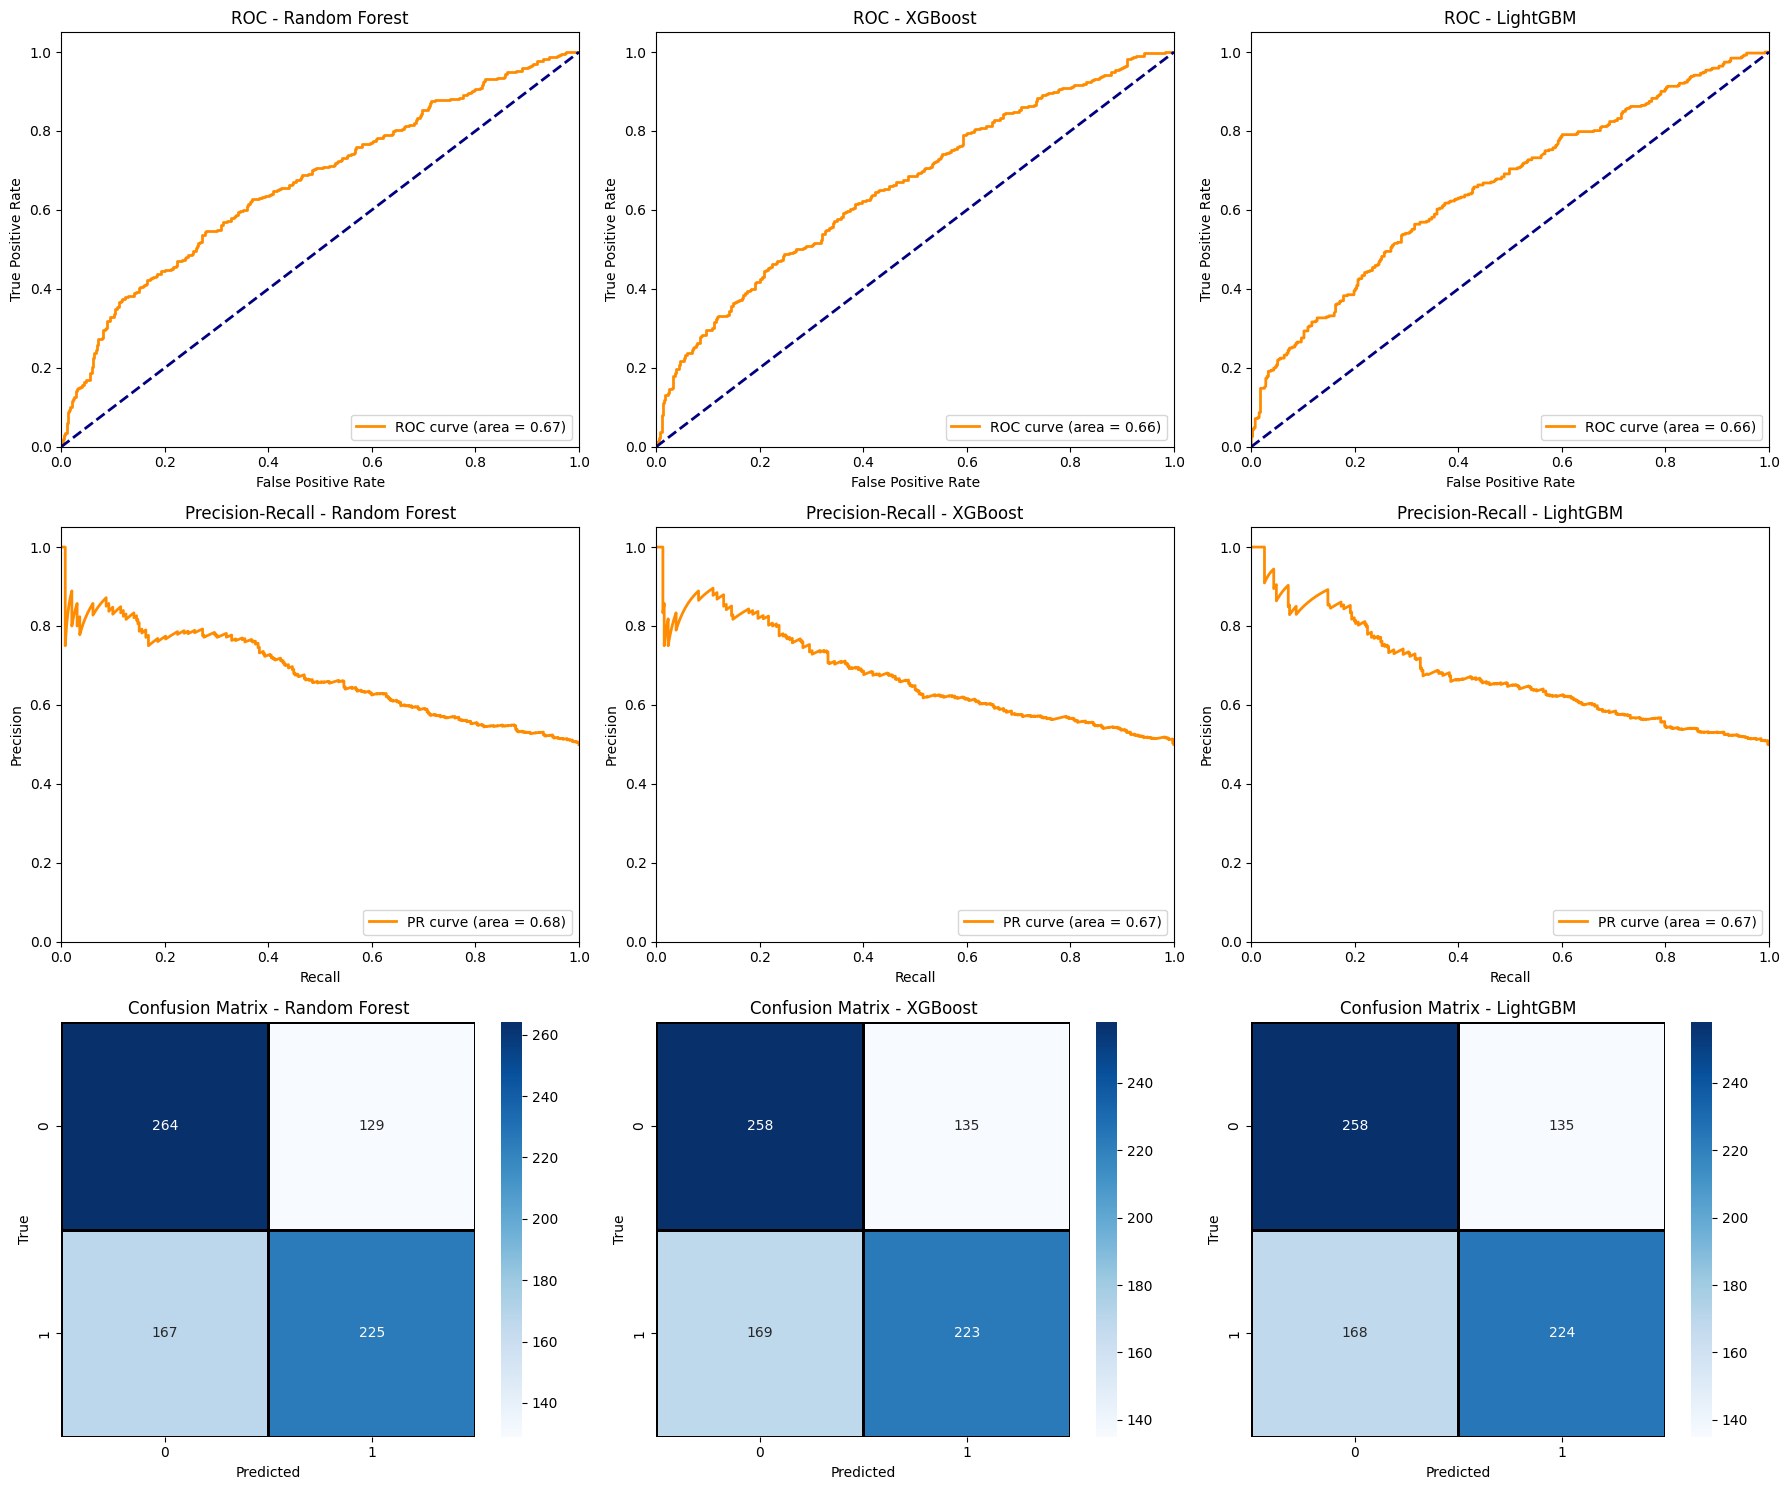

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_all_metrics(models, X_test, y_test, model_names):
    fig, axes = plt.subplots(nrows=3, ncols=len(models), figsize=(18, 15))
    
    for i, model in enumerate(models):
        # ROC Curve
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axes[0, i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0, i].set_xlim([0.0, 1.0])
        axes[0, i].set_ylim([0.0, 1.05])
        axes[0, i].set_xlabel('False Positive Rate')
        axes[0, i].set_ylabel('True Positive Rate')
        axes[0, i].set_title(f'ROC - {model_names[i]}')
        axes[0, i].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1, i].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        axes[1, i].set_xlim([0.0, 1.0])
        axes[1, i].set_ylim([0.0, 1.05])
        axes[1, i].set_xlabel('Recall')
        axes[1, i].set_ylabel('Precision')
        axes[1, i].set_title(f'Precision-Recall - {model_names[i]}')
        axes[1, i].legend(loc="lower right")
        
        # Confusion Matrix
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black', ax=axes[2, i])
        axes[2, i].set_xlabel('Predicted')
        axes[2, i].set_ylabel('True')
        axes[2, i].set_title(f'Confusion Matrix - {model_names[i]}')

    plt.tight_layout()
    plt.savefig(os.path.join(visual_dir, f'metrics_{trial_number_ml}.png'))
    plt.show()

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
plot_all_metrics(models, X_test, y_test, model_names)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, model_name='Model'):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, model_name='Model'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=2, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

models = [best_rf, best_xgb, best_lgb]
model_names = ['Random Forest', 'XGBoost', 'LightGBM']
metrics_list = []

def evaluate_model_performance(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
    }
    return metrics


# Plotting functions modified to save figures
def plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml):
    for model, model_name in zip(models, model_names):
        # ROC Curve
        plot_roc_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'roc_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Precision-Recall Curve
        plot_precision_recall_curve(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'precision_recall_curve_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()
        
        # Confusion Matrix
        plot_confusion_matrix(model, X_test, y_test, model_name)
        plt.savefig(os.path.join(visual_dir, f'confusion_matrix_{model_name}_{trial_number_ml}.png'), dpi=300)
        plt.close()



In [12]:
# Evaluate and save metrics for each model
for model, name in zip(models, model_names):
    metrics = evaluate_model_performance(model, X_test, y_test, name)
    metrics_list.append(metrics)
    print(f"Metrics for {name}: {metrics}")

# Convert metrics to DataFrame sort bu 'Accuracy' and save
metrics_df = pd.DataFrame(metrics_list)
sorted_metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
sorted_metrics_df.to_csv(os.path.join(results_dir, f'sorted_metrics_df_{trial_number_ml}.csv'), index=False)

Metrics for Random Forest: {'Model': 'Random Forest', 'Accuracy': 0.6229299363057325, 'Precision': 0.635593220338983, 'Recall': 0.5739795918367347, 'F1 Score': 0.6032171581769437, 'ROC AUC': 0.6690943552993716}
Metrics for XGBoost: {'Model': 'XGBoost', 'Accuracy': 0.6127388535031847, 'Precision': 0.6229050279329609, 'Recall': 0.5688775510204082, 'F1 Score': 0.5946666666666666, 'ROC AUC': 0.6619670769070987}
Metrics for LightGBM: {'Model': 'LightGBM', 'Accuracy': 0.6140127388535032, 'Precision': 0.6239554317548747, 'Recall': 0.5714285714285714, 'F1 Score': 0.5965379494007989, 'ROC AUC': 0.657484940541102}


In [13]:
metrics

{'Model': 'LightGBM',
 'Accuracy': 0.6140127388535032,
 'Precision': 0.6239554317548747,
 'Recall': 0.5714285714285714,
 'F1 Score': 0.5965379494007989,
 'ROC AUC': 0.657484940541102}

In [14]:
# Assuming you have a list called metrics_list which contains the metrics dictionaries for each model
# And assuming each dictionary has a 'Model' key with the model's name and an 'Accuracy' key with its accuracy

# Extract accuracy scores and model names from metrics_list
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
model_names = [metrics['Model'] for metrics in metrics_list]

# Find the index of the highest accuracy
best_model_index = accuracy_scores.index(max(accuracy_scores))

# Retrieve the best model and its name using the index
best_model = models[best_model_index]
best_model_name = model_names[best_model_index]

# Print the best model name and its accuracy
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_index]:.4f}")


Best Model: Random Forest with Accuracy: 0.6229


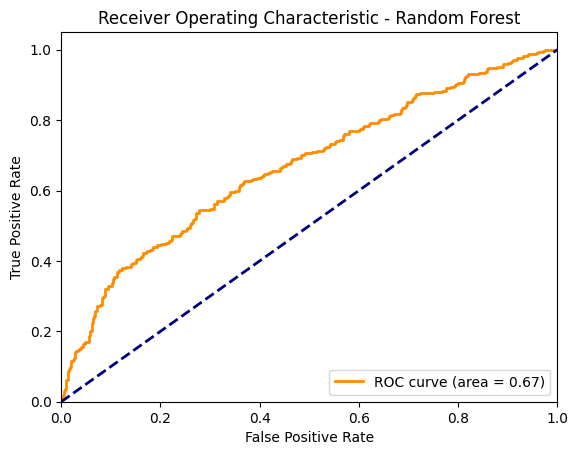

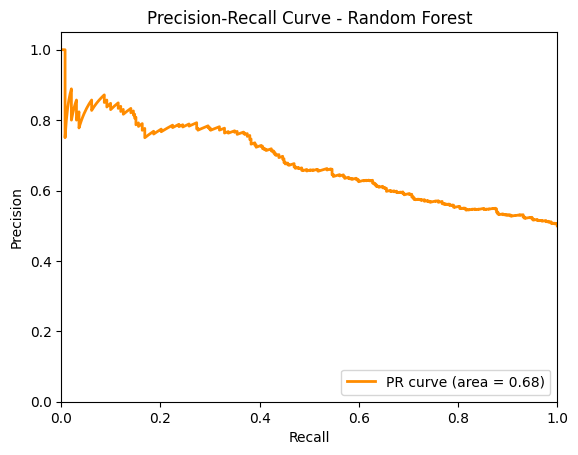

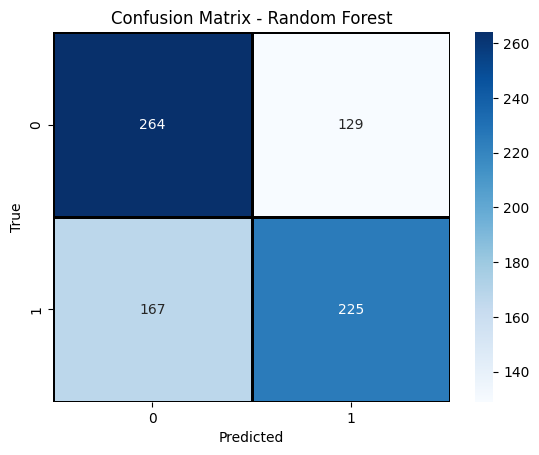

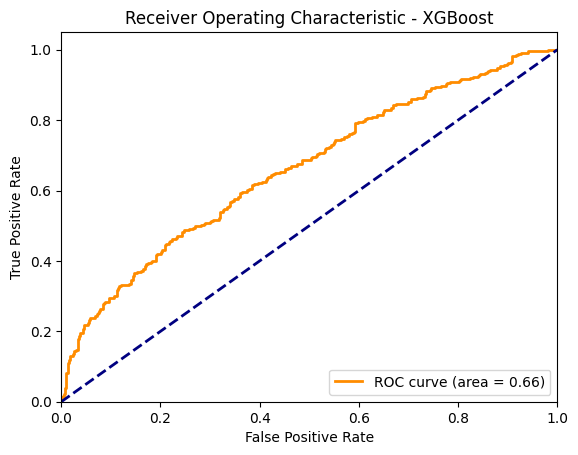

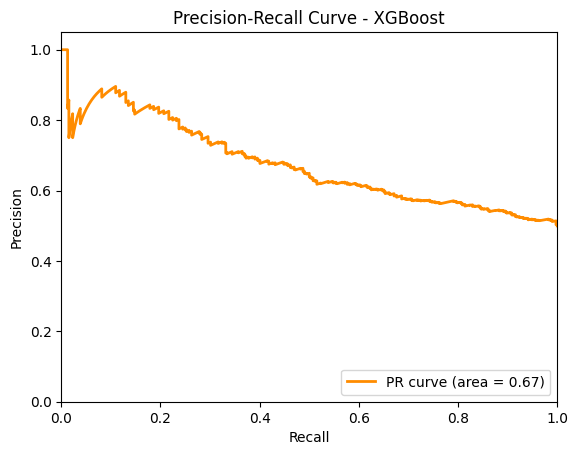

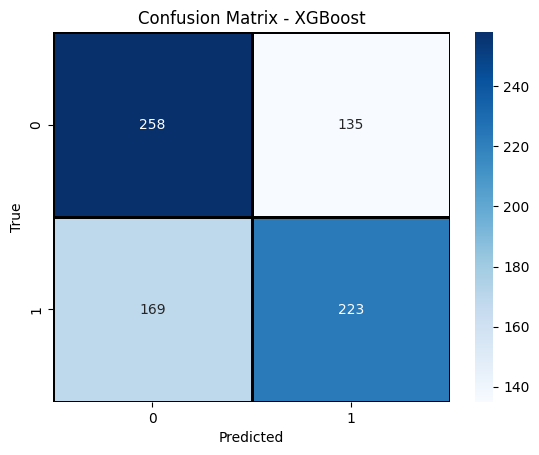

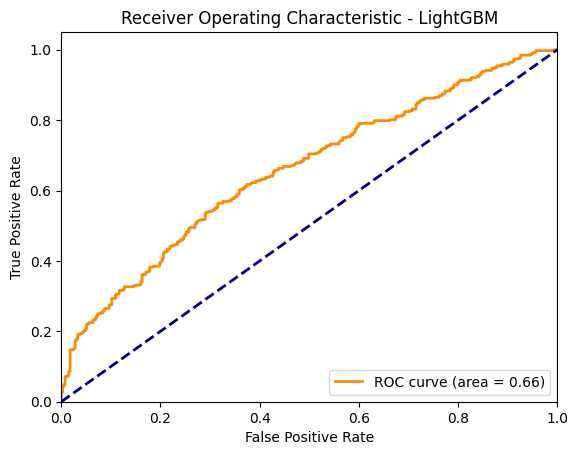

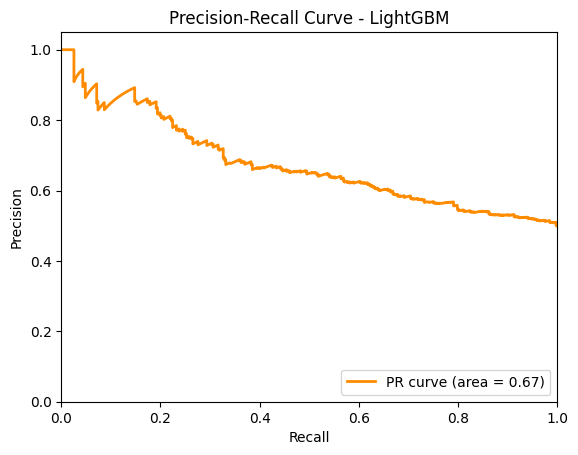

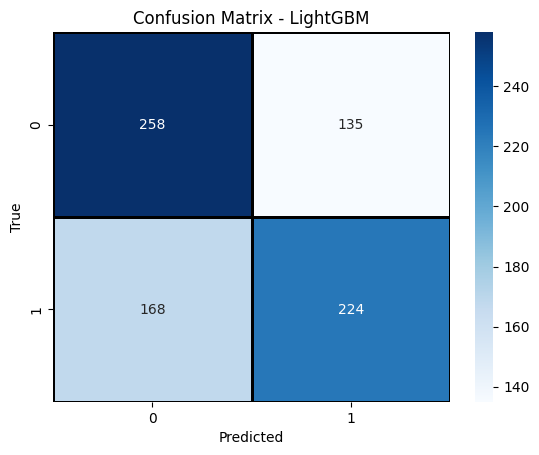

In [15]:
plot_and_save_figures(models, X_test, y_test, model_names, trial_number_ml)


In [16]:
def extract_feature_importances(model, feature_names):
    """
    Extract and sort the feature importances from the model.
    """
    feature_importances = model.feature_importances_
    sorted_idx = np.argsort(feature_importances)[::-1]
    return feature_names[sorted_idx], feature_importances[sorted_idx]

def plot_feature_importances(feature_names, feature_importances, title='Feature Importances', n_features=20):
    """
    Visualize the top N feature importances for interpretability.
    """
    plt.figure(figsize=(10, 8))
    sns.barplot(x=feature_importances[:n_features], y=feature_names[:n_features], orient='h')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature (Bit Index)')
    plt.savefig(os.path.join(features_dir, f'feature_importances_{trial_number_ml}.png'), dpi=300)
    plt.show()

def identify_important_features(feature_names, feature_importances, threshold=0.002):
    """
    Identify features with importance greater than a specified threshold.
    """
    return feature_names[feature_importances > threshold], feature_importances[feature_importances > threshold]

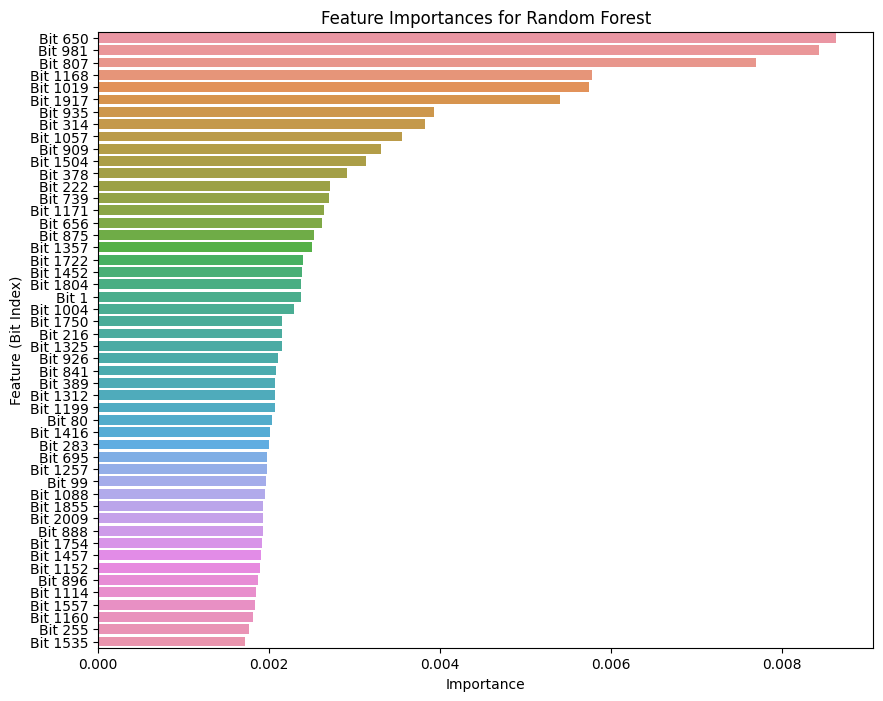

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib

feature_names = np.array(["Bit " + str(i) for i in range(X_train.shape[1])])  # Adjust based on your X_train


def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Save to CSV
    features_df = pd.DataFrame({
        'Feature': sorted_names,
        'Importance': sorted_importances
    })
    csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}.csv')
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=50)
    plt.close()

save_feature_importances(best_model, feature_names, best_model_name, trial_number_ml)


In [18]:
import time

def save_feature_importances(model, feature_names, model_name, trial_number):
    sorted_names, sorted_importances = extract_feature_importances(model, feature_names)
    
    # Define file paths
    timestamp = time.strftime("%Y%m%d-%H%M%S")  # Current timestamp
    csv_filename = f'feature_importances_{model_name}_{trial_number}.csv'
    plot_filename = f'feature_importances_plot_{model_name}_{trial_number}.png'
    
    # Check if files exist and append timestamp to avoid overwriting
    csv_path = os.path.join(features_dir, csv_filename)
    if os.path.exists(csv_path):
        csv_path = os.path.join(features_dir, f'feature_importances_{model_name}_{trial_number}_{timestamp}.csv')
    
    plot_path = os.path.join(features_dir, plot_filename)
    if os.path.exists(plot_path):
        plot_path = os.path.join(features_dir, f'feature_importances_plot_{model_name}_{trial_number}_{timestamp}.png', dpi=300)

    # Save to CSV
    features_df = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importances})
    features_df.to_csv(csv_path, index=False)
    
    # Plot and save visualization
    plot_feature_importances(sorted_names, sorted_importances, f'Feature Importances for {model_name}', n_features=20)
    plt.savefig(plot_path)
    plt.close()
